#  Introdução e Questão Central

Em maio de 2021, o Laboratório Espaço Público e Direito à Cidade associado à Faculdade de Arquitetura e Urbanismo da Universidade de São Paulo publicou o artigo [*Prioridade na vacinação negligencia a geografia da Covid-19 em São Paulo*](http://www.labcidade.fau.usp.br/prioridade-na-vacinacao-negligencia-a-geografia-da-covid-19-em-sao-paulo/). As ótimas visualizações de dados sobre COVID-19 mostraram a distribuição geográfica na cidade de São Paulo de contágios, internações, mortes e vacinações, de forma agregada desde o início da pandemia.

<div style="text-align: center;">
    <img src="../reports/figures/labcidade.png" width=70%><p style="display: block; text-align:center"><i>Fonte: labcidade.fau.usp.br</i></p>
</div>

A imagem acima abre o artigo e contém o modelo de mapa que será explorado com diversas variáveis. Nos restringindo apenas a essa imagem, é possível visualizar uma maior concentração de casos na periferia (cores mais intensas na metade esquerda), enquanto a concentração de vacinação apresentam uma distribuição exatamente inversa (cores mais intensas na metade direita). Esta segregação geográfica é recorrente nos diversos gráficos apresentados e reflete a profunda desigualdade da cidade de São Paulo em diversas manifestações: sanitárias, censitárias, raciais, sociais... 

No entanto, esta desigualdade geográfica não é restrita a esta cidade, nem ao tema sanitário, que é o ponto central da análise do artigo. 

<div class='alert alert-info' style="font-size: medium">
Diante disto, fiquei instigado sobre a seguinte questão: a distribuição geográfica de vacinações no Brasil apresentaria algum padrão semelhante a este? Dito de outra forma, <strong>seria possível encontrar desigualdades recorrentes na imunização das populações das diferentes Unidades da Federação?</strong> Esta é a pergunta que guia toda a análise deste caderno.
</div>

Afinal, se houver tal padrão histórico que indique que certas Unidades Federativas possuem taxas de imunização maiores do que outras, teríamos evidências para rejeitar a hipótese de que este mesmo padrão possa ser reproduzido na distribuição de imunizações contra a COVID-19? 

Para explorar esta questão, utilizaremos dados do DataSUS sobre o Programa Nacional de Imunizações para comparar as coberturas vacinais agregadas nas 27 unidades federativas brasileiras entre 2017 e 2020, um intervalo de 4 anos.

*Para mais informações sobre os dados, veja o [caderno 2](./2_-_preparacao_dos_dados.ipynb).*

# Preparando o ambiente


In [1]:
from IPython.display import Markdown
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from mapclassify import classify

from my_modules.brazil_colors import brazil_colormaps, create_ordered_colormap
from my_modules.brazil_states_geodata import estados_geo, geo_colors_plot
from my_plots import mono_br_geoplot, double_br_geoplot, podium_swarmplot

In [2]:
def print_html(text: str, alert_type: str = '', fontsize:str = 'small'):
    """
    alert_type: info(blue), danger(red), warning(yellow), success(green)
    font-size: descriptive(small, medium...); pixels (12px, 20px....); percentage (120%)
    """
    alert_type = f'class="alert alert-{alert_type}"' if alert_type != '' else ''
    html = f'<div {alert_type} style="font-size: {fontsize}">{text}</div>'
    display(HTML(html))

    
# setting matplotlib parameters for the whole notebook
plt.rcParams.update({
    'font.size': 12.0,
    'axes.labelsize': 'large',
    'axes.labelpad': '10.0',
    'axes.titlesize': 20,
    'figure.titlesize': 28,
    'figure.titleweight':'bold',
    'legend.title_fontsize': 'large',
})

## Referência: Cores e Siglas

Ao longo do caderno, serão utilizados os padrões de cores expostos no gráfico abaixo em relação à regiões e unidades federativas.

Norte - Verde | Nordeste - Vermelho | Sudeste - Roxo | Sul - Azul | Centro-Oeste - Laranja/Amarelo

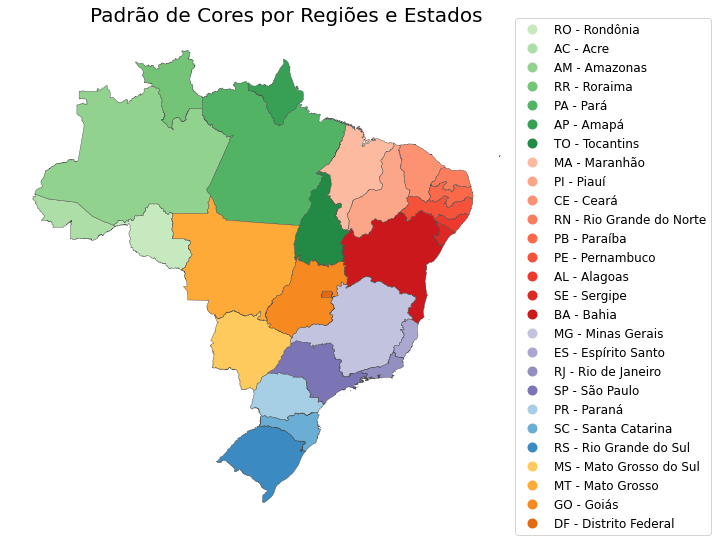

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
geo_colors_plot(estados_geo, brazil_colormaps['States'], ax=ax)

## Dados

In [8]:
processed_datadir = '../data/processed/'
filename = '2017_2020_coberturas_vacinais_por_imuno_segundo_unidade_da_federacao'
path = processed_datadir + filename + '.csv.gz'

imunizacao_ufs = pd.read_csv(path, encoding='ISO-8859-1', sep =';', compression='gzip')

Conforme trabalhado no caderno 2, os dados utilizados são compostos por:

`Unidades Federativas (uf)`: estados brasileiros e distrito federal ~ 27 valores

`Imunos`: no caderno 2 estão explicitadas as imunos, no entanto, neste caderno não serão utilizadas de forma segregada, pois o objetivo é comparar os valores agregados de imunização entre os Estados ~ 21 valores

`Anos`: 2017 a 2020 ~  4 valores

`Cobertura Vacinal`: proporção da população estimada imunizada para cada combinação das outras três variáveis ~ 2268 valores

In [6]:
display(imunizacao_ufs.info(), imunizacao_ufs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268 entries, 0 to 2267
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uf                 2268 non-null   object 
 1   imuno              2268 non-null   object 
 2   ano                2268 non-null   int64  
 3   cobertura_vacinal  2268 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 71.0+ KB


None

,uf,imuno,ano,cobertura_vacinal
0,Rondônia,BCG,2017,97.81
1,Acre,BCG,2017,96.83
2,Amazonas,BCG,2017,93.82
3,Roraima,BCG,2017,116.74
4,Pará,BCG,2017,85.83
...,...,...,...,...
2263,Rio Grande do Sul,dTpa gestante,2020,53.54
2264,Mato Grosso do Sul,dTpa gestante,2020,52.92
2265,Mato Grosso,dTpa gestante,2020,58.15
2266,Goiás,dTpa gestante,2020,46.44


# Anos Agregados (2017-2020)

Primeiro podemos visualizar os dados de coberturas vacinais para todos os 4 anos e 21 imunos, segmentando apenas por estado. Neste caso cada unidade federativa terá 84 pontos agrupados verticalmente. 

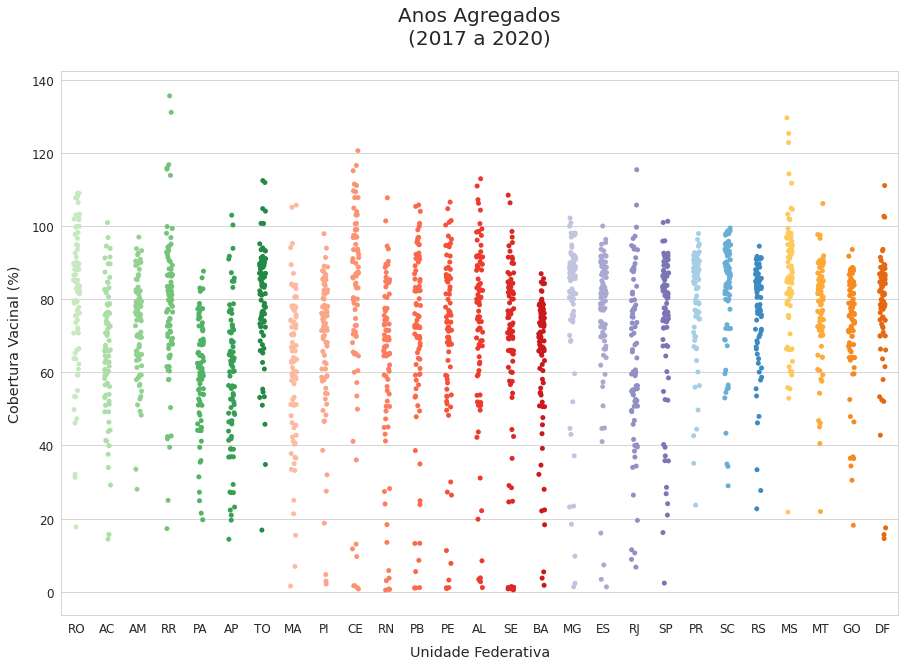

In [7]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot()
    sns.stripplot(ax=ax, data=imunizacao_ufs, x = 'uf', y = 'cobertura_vacinal',
                 palette=brazil_colormaps['States'].colors)#, hue='ano')
    ax.set_xticklabels(estados_geo.sigla.to_list())
    ax.set(xlabel= "Unidade Federativa", ylabel= 'Cobertura Vacinal (%)', title="Anos Agregados\n(2017 a 2020)\n")
    plt.show()

Comecemos explorando os extremos. Os valores acima de 100% e os valores abaixo de 20%. Afinal o quanto estes valores representam em relação ao total? Deveríamos retirá-los?
    

In [9]:
menor_que_20 = len(imunizacao_ufs.query("cobertura_vacinal<20")) / len(imunizacao_ufs)
maior_que_100 = len(imunizacao_ufs.query("cobertura_vacinal>100")) / len(imunizacao_ufs)
entre_20_e_100 = 1 - (menor_que_20 + maior_que_100)

html = 'Vemos que as observações inferiores a 20% representam <b>{:.2f}%</b> do número total, enquanto os valores acima de 100% representam <b>{:.2f}%</b> do total.<br>Portanto, os outros <b>{:.2f}%</b> das observações possuem entre 20% e 100% de cobertura vacinal.'.format(menor_que_20*100, maior_que_100*100, entre_20_e_100*100)
print_html(html, 'info', 'medium')

Como o objetivo desta exploração é a relação entre as unidades federativas, os valores acima de 100% não são problemáticos por si só. Poderiam ser caso alguns estados específicos possuíssem uma grande quantidade de valores nesta faixa. No nosso caso não impactarão tanto, pois analisaremos a relação entre as unidades federativas a partir da média dos valores.

Um questionamento semelhante seria: qual o intervalo que contém **metade** das observações?

In [15]:
Q1_2017_2020 = imunizacao_ufs.cobertura_vacinal.describe()['25%']
Q3_2017_2020 = imunizacao_ufs.cobertura_vacinal.describe()['75%']

html = 'Metade das observações sobre coberturas vacinais dos últimos 4 anos está entre <strong>{:.2f}% e {:.2f}%</strong>.'.format(Q1_2017_2020, Q3_2017_2020)
print_html(html, "info", 'medium')
Markdown('Graficamente, isto significa que metade de todos os pontos do gŕafico estão localizados na área de cor cinza abaixo, sobreposta ao gráfico anterior.')

Graficamente, isto significa que metade de todos os pontos do gŕafico estão localizados na área de cor cinza abaixo, sobreposta ao gráfico anterior.

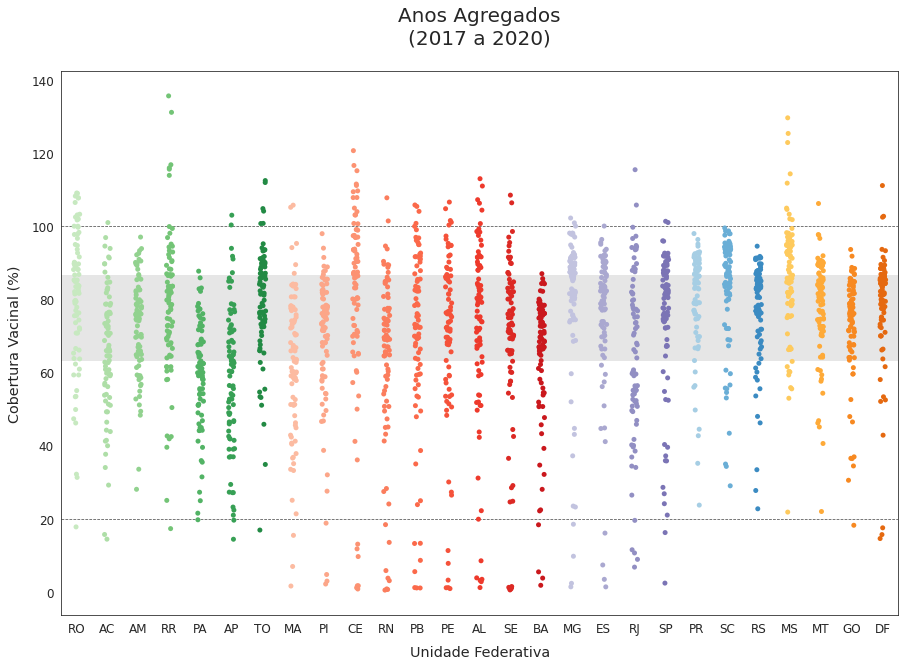

In [47]:
with sns.axes_style('white'):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot()

    sns.stripplot(ax=ax, data=imunizacao_ufs, x = 'uf', y = 'cobertura_vacinal',
                 palette=brazil_colormaps['States'].colors)#, hue='ano')

    ax.set_xticklabels(estados_geo.sigla.to_list())
    
    # horizontal lines
    ax.axhline(y=20, xmin=0, xmax=1, linestyle="--", color='0.3', linewidth=0.75)
    ax.axhline(y=100, xmin=0, xmax=1, linestyle="--", color='0.3', linewidth=0.75)
    
    # add gray area for interquartile range
    ax.axhspan(ymin=Q1_2017_2020, ymax=Q3_2017_2020, facecolor = '0.9')

    ax.set(xlabel= "Unidade Federativa", ylabel= 'Cobertura Vacinal (%)', title="Anos Agregados\n(2017 a 2020)\n")
    plt.show()

Até agora tivemos uma visão geral da situação agregada dos 4 anos, mas seria interessante também segmentar para cada ano, visualizando melhor mudanças ao longo do tempo. É o que faremos agora.

# Anos Separados (2017-2020)

In [96]:
intervalo_interquartil_por_ano = {}
for ano in range(2017,2021):
    with sns.axes_style('white'):
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot()

        data_to_plot= imunizacao_ufs.query("ano==@ano")

        sns.stripplot(ax=ax, data=data_to_plot, x = 'uf', y = 'cobertura_vacinal',
                     palette=brazil_colormaps['States'].colors)#, hue='ano')

        Q1 = data_to_plot.cobertura_vacinal.describe()['25%']
        Q3 = data_to_plot.cobertura_vacinal.describe()['75%']
        intervalo_interquartil_por_ano[ano] = (Q1, Q3)
            
        ax.set_xticklabels(estados_geo.sigla.to_list())
        ax.axhline(y=100, xmin=0, xmax=1, linestyle="--", color='0.3', linewidth=0.75)
        ax.set_ylim(0,140)
        ax.set(xlabel= "Unidade Federativa", ylabel= 'Cobertura Vacinal (%)', title=ano)
        ax.axhspan(ymin=Q1, ymax=Q3, facecolor = '0.9')
        
        fig.savefig("../reports/figures/swarmplots/" + str(ano) + "_to_gif.png")
        plt.close()
#         plt.show()

# printing interquartile range by year
print('\n Ano: Fronteiras da área cinza onde se concentram metade dos valores')
for ano, (q1, q3) in intervalo_interquartil_por_ano.items():
    print('{}: {:.2f} ~ {:.2f}'.format(ano, q1, q3))
print('')


 Ano: Fronteiras da área cinza onde se concentram metade dos valores
2017: 65.04 ~ 85.82
2018: 66.61 ~ 91.22
2019: 66.37 ~ 87.69
2020: 55.53 ~ 81.30



![swarmplot-gif](../reports/figures/swarmplot_2017_2020.gif)

*[Clique aqui para ver o GIF em escala ampliada](../reports/figures/swarmplot_2017_2020.gif)*

---

Ao segregar a série acima para cado ano do período, é possível notar algumas coisas, como:

- Em primeiro lugar, há uma queda generalizada da cobertura vacinal em 2020. Muito provavelmente a causa é a pandemia.

- A região Nordeste é a que possui pontos mais baixos em todos os anos.

- Estados da região Sul nunca passam de 100%, possuem pouca variação e geralmente estão entre os mais altos.

Apesar destas informações, até agora não fomos capazes de extrair muita informação comparativa entre estados, apenas de como a série geral se comportou ao longo dos anos.

-------

# Comparando Estados

Agora indo de fato a pergunta inicial: existe algum padrão recorrente entre estados na questão da imunização?

Para comparar os estados, podemos agrupá-los em grupos indo dos piores aos melhores quanto a taxa de cobertura vacinal. Usaremos a média de valores de cobertura vacinal para cada estado no ano escolhido, sem diferenciar por imunos.

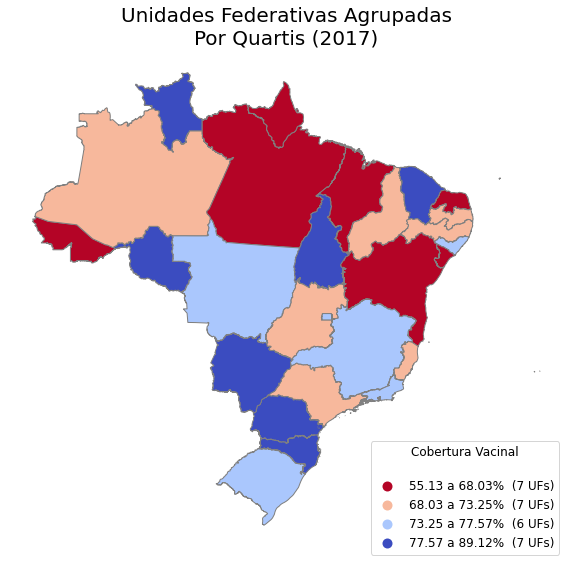

In [5]:
mono_br_geoplot(ano=2017, gdf=estados_geo, df=imunizacao_ufs, which_plot=0)

Aqui temos 4 grupos, cada um deles com 6 ou 7 unidades federativas.

O valor de 73.25% divide os 27 estados aproximadamente ao meio. Em azul temos os 13 estados acima desta "metade" - mais conhecida como mediana - e em vermelho, os 14 estados abaixo dela.

In [11]:
print_html('Os 7 <strong>piores</strong> estados no ano estão em <strong>vermelho escuro</strong>.', 'danger', 'medium')
print_html('Os 7 <strong>melhores</strong> estados no ano estão em <strong>azul escuro</strong>.', 'info', 'medium')

Porém, esta classificação não ajudaria a notar aquela queda em 2020, como já vimos anteriormente. Portanto, uma outra classificação onde os valores não mudam seria útil para analisar estas variações entre os anos.

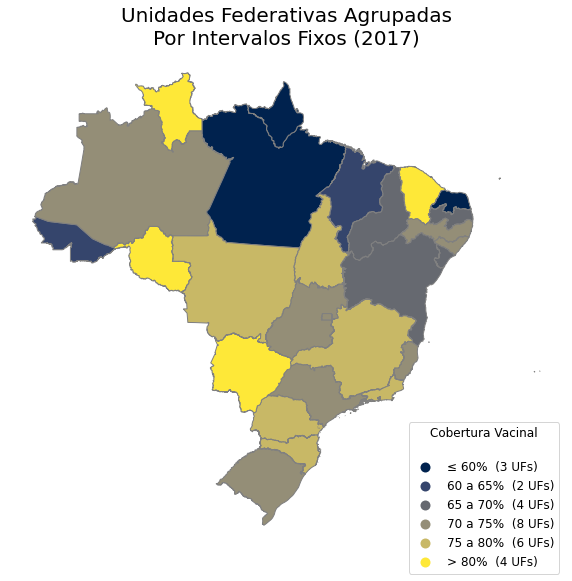

In [13]:
mono_br_geoplot(ano=2017, gdf=estados_geo, df=imunizacao_ufs, which_plot=1)
print_html('<i>Nota Técnica: intervalos "x a y" na forma (x, y]. Apenas y está contido no intervalo.</i>', 'small')

Aqui temos outra visualização. Não temos mais uma quantia semelhante de estados em cada grupo, o foco aqui é entender como eles se deslocam entre grupos no tempo. Será que teremos algum mapa muito amarelado em algum ano? Podemos afirmar, por exemplo, que 2020 possuirá a menor quantia de tons amarelos, pela queda na cobertura vacinal nacional neste ano.

In [28]:
print_html('Quanto mais amarelado, mais próximo o estado está da marca de 80% ou mais de cobertura vacinal.',
           'warning', fontsize='medium')

Uma boa forma de visualizar ambos os mapas para os 4 anos de forma a "entender" a movimentação dos dados, é utilizando o GIF abaixo *(clique [aqui](../reports/figures/cloropleth_2017_2020.gif) para ver em escala ampliada)*

In [119]:
for ano in range(2017,2021):
    double_br_geoplot(ano=ano, gdf=estados_geo, df=imunizacao_ufs, save=True)

![cloropleth-gif](../reports/figures/cloropleth_2017_2020.gif)

Este GIF é muito interessante pela quantidade de informações disponíveis. Vamos explorar algumas.

No gráfico da esquerda, parece haver uma tendência em alguns estados de variar entre tons de azul (Região Sul e Centro-Oeste, com exceção de Goiás), enquanto outros variam entre os 2 piores grupos, em tons de vermelho (como o Nordeste), ou permanecem fixos no vermelho escuro pelos 4 anos, como é o caso do Pará e Amapá. 

In [14]:
html= 'Parecem haver indícios de desigualdades recorrentes, como vinhamos buscando.'
print_html(html, 'success', 'medium')

Olhando agora para o gráfico da direita, podemos notar que apesar das afirmações anteriores serem relativas entre os estados, a discrepância entre estados se repete na classificação por intervalos fixos. Em 2018, por exemplo, vemos um grande "amarelar" do mapa, com 12 estados passando de 80% de cobertura vacinal. Enquanto isso, os mesmos estados que tendem ao vermelho no gráfico da esquerda, aqui ficaram até com menos cobertura vacinal em 2018 do que em 2017, embora houvesse uma melhoria em grande parte dos estados do brasil.

Outro olhar interessante é notar a mudança na quantidade de estados em cada categoria. Em 2018 e 2019, não tivemos nenhum estado abaixo de 60%. Porém, em 2020 este número foi para 9.

Como existem diversas formas de abordar estes gráficos, deixo aos leitores e leitoras explorarem seus próprios estados e regiões, fixando o olhar neles e observando suas variações nos anos ou suas relações com estados vizinhos. As possibilidades são muitas. Por exemplo, se escolhermos o estado do Ceará, veremos como ele foge ao padrão do Nordeste, sendo o único desta região a atingir mais de 80% de cobertura vacinal média por dois anos, o que o colocou entre os 7 melhores estados, sendo colorido de azul escuro em 2017 e 2018.

Para finalizar, seria interessante criar alguma forma de agrupamento destas colocações. Algo como um pódio. Podemos contar o número de vezes que cada estado foi classificado em um dos quatro grupo vermelhos-azuis. 

# Conclusões

<Figure size 432x288 with 0 Axes>

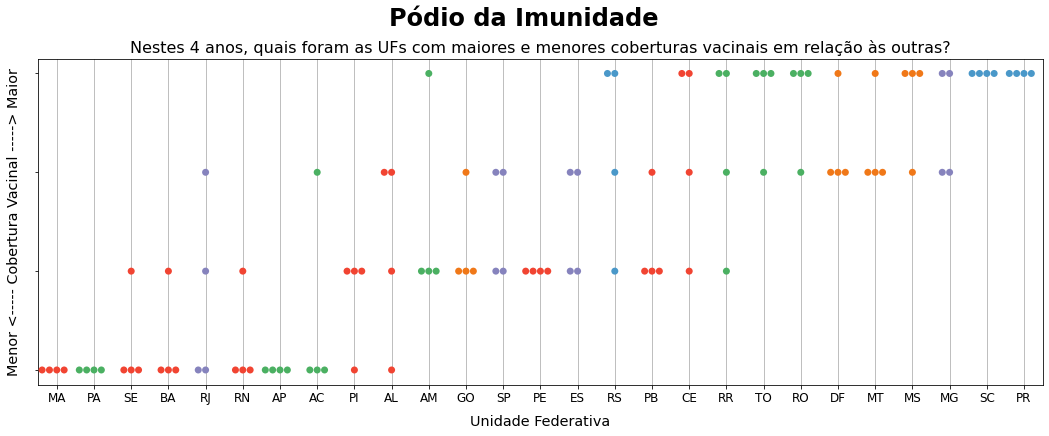

In [7]:
podium_swarmplot(imunizacao_ufs, estados_geo)

Podemos confirmar com mais precisão algumas das colocações levantadas no parágrafo acima, ao analisar o GIF do mapa azul e vermelho:

- Maranhão, Pará e Amapá estiveram 4 vezes no pior grupo.

- A região Nordeste ocupa majoritariamente os 2 piores grupos.

- Santa Catarina e Paraná estiveram nos 4 anos no grupo com mais cobertura vacinal.

Talvez a observação mais importante para o questionamento deste caderno seja que: **não há nenhum estado que tenha se posicionado no pior e no melhor grupo.** Todos os que estiveram pelo menos uma vez no grupo dos piores 7, não possuem nenhuma aparição no melhor grupo. Consequentemente, o inverso também é verdadeiro: se um estado esteve entre os 7 com maior cobertura vacinal em ao menos 1 dos 4 anos, ele terá zero ocorrências entre os piores 7.

In [6]:
html='Observando este pódio podemos retomar a pergunta inicial com outros olhos. Afinal, fomos capazes de encontrar <strong>desigualdades recorrentes na imunização das populações das diferentes Unidades da Federação</strong>. É isto que vemos, com as Unidades Federativas localizadas do lado esquerdo do "Pódio da Imunidade" concentrando posições no pior grupo, enquanto os estados à direita concentram posições no grupo com melhores indices de cobertura vacinal.'
print_html(html, 'success', 'medium')

# Próximos Passos

- Extender a análise para incluir dados de vacinação da covid-19, para verificar se estes padrões de desigualdade entre unidades federativas vem se reproduzindo da mesma forma

# Referências

[Choropleth Maps - A Guide to Data Classification - GIS Geography](https://gisgeography.com/choropleth-maps-data-classification/)

[Choropleth Mapping — Geographic Data Science with Python](https://geographicdata.science/book/notebooks/05_choropleth.html)

# Contato

Murilo Amaral

mumaral@protonmail.com

https://github.com/mumaral

https://linkedin.com/in/mumaral